# Ch 10. Working with Data

In [1]:
from collections import Counter, defaultdict
from functools import partial, reduce
from linear_algebra import shape, get_row, get_column, make_matrix, vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply
import math, random, csv
from stats import correlation, standard_deviation, mean
from probability import inverse_normal_cdf
from gradient_descent import maximize_batch
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser

<Figure size 432x288 with 0 Axes>

## Exploring Your Data

#### **Exploring One-Dimensional Data**
- The simplest case is when you have a one-dimensional data set
- The smallest, the largest, the mean, and the standard deviation, histogram

In [2]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

In [3]:
random.seed(0)
# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]
# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

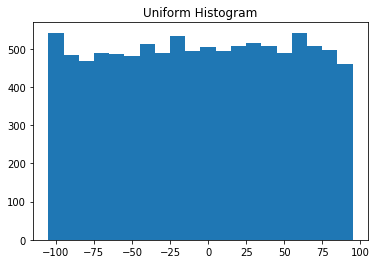

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

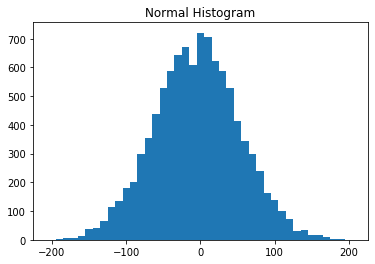

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

In [6]:
def compare_two_distributions():
    
    random.seed(0)
    
    uniform = [random.randrange(-100,101) for _ in range(200)]
    normal = [57 * inverse_normal_cdf(random.random())
              for _ in range(200)]
    
    plot_histogram(uniform, 10, "Uniform Histogram")
    plot_histogram(normal, 10, "Normal Histogram")

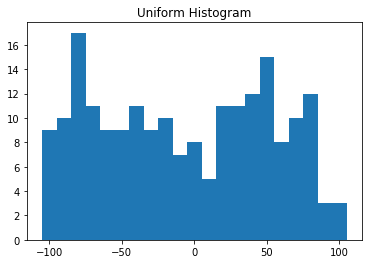

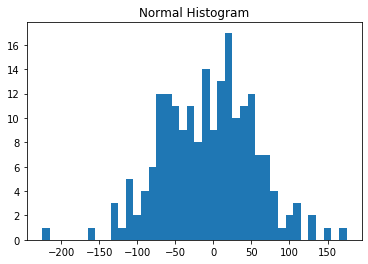

In [7]:
compare_two_distributions()

### **Two Dimensions**
- Now, you have data set with two dimensions.
- Firstly, we want to understand each dimension individually.
- Then, you probably also want to scatter the data.

In [8]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

In [9]:
def scatter():
    plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
    plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
    plt.xlabel('xs')
    plt.ylabel('ys')
    plt.legend(loc=9)
    plt.show()

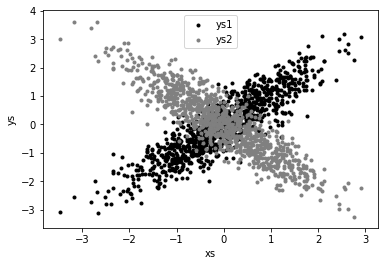

In [10]:
scatter()

In [11]:
print(correlation(xs, ys1))
print(correlation(xs, ys2))

0.891585944012268
-0.8939937075957362


#### **Many Dimensions**
- You’d like to know how all the dimensions relate to one another.
- A simple approach is to look at the correlation matrix
- A more visual approach (if you don’t have too many dimensions) is to make a scatterplot matrix showing all the pairwise scatterplots.

In [12]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""
    
    _, num_columns = shape(data)
    
    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [13]:
def make_scatterplot_matrix():
    
    # first, generate some random data
    
    num_points = 100
    
    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]
    
    # then plot it
    
    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)
    
    for i in range(num_columns):
        for j in range(num_columns):
            
            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))
                
            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")
                
            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)
                
    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())
    
    plt.show()

    print('### Correlation Matrix ###')
    import numpy as np
    print(np.array(correlation_matrix(data)))
    print()
    print('### Correlation Matrix using numpy.corrcoef() ###')
    print(np.corrcoef(np.array(data).T))

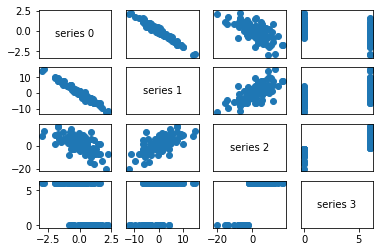

### Correlation Matrix ###
[[ 1.         -0.98113582 -0.66174938 -0.51732231]
 [-0.98113582  1.          0.68181854  0.54211527]
 [-0.66174938  0.68181854  1.          0.74614437]
 [-0.51732231  0.54211527  0.74614437  1.        ]]

### Correlation Matrix using numpy.corrcoef() ###
[[ 1.         -0.98113582 -0.66174938 -0.51732231]
 [-0.98113582  1.          0.68181854  0.54211527]
 [-0.66174938  0.68181854  1.          0.74614437]
 [-0.51732231  0.54211527  0.74614437  1.        ]]


In [14]:
make_scatterplot_matrix()

#### **Cleaning and Munging**
- Real-world data is dirty.
- **Dirty, Dirty, Dirty!!!**
- Often you’ll have to do some work on it before you can use it.
- Use None to represent “don’t do anything to this column”
- You will write a **parser similar to the following code** in handling real-world data processing
- Munge (Computer Slang): to manipulate (raw data), especially to convert (data) from one format to another

### **Example: comma_delimited_stock_prices.csv**

In [15]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

In [16]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none


In [17]:
!type csv\comma_delimited_stock_prices.csv


AAPL,6/20/2014,90.91
MSFT,6/20/2014,41.68
FB,6/20/3014,64.5
AAPL,6/19/2014,91.86
MSFT,6/19/2014,n/a
FB,6/19/2014,64.34


In [20]:
import dateutil.parser
data = []

with open("csv\comma_delimited_stock_prices.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)
        
for row in data:
    if any(x is None for x in row):
        print(row)

ParserError: Unknown string format: AAPL

In [ ]:
# this provides new definition of parse_row
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
    for value, parser in zip(input_row, parsers)]

### **stocks.txt**

In [ ]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.items() }

In [ ]:
!type txt\stocks.txt

In [ ]:
with open("txt\stocks.txt", "r", encoding='utf8', newline='') as f:
    reader = csv.DictReader(f, delimiter="\t")
    data = [parse_dict(row, { 'date' : dateutil.parser.parse,
                             'closing_price' : float })
            for row in reader]
    
print(len(data))
print(data[:2])
max_aapl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL")
print("max aapl price", max_aapl_price)

## **You do not really understand something unless you can explain it to your grandmother. -- Albert Einstein**

### **Dimensionality Reduction: Principal Component Analysis(PCA)**

1. Find a PCA component w
$$ w = armax_{|w|=1}\sum_{i} (x_i \centerdot w)^2$$
2. Project all points on a hyperplane perpendicular to w
3. Repeat step 1, 2

<img src = "picture/le10-1.png">

In [ ]:
DATA = [
 [20.9666776351559,-13.1138080189357],
 [22.7719907680008,-19.8890894944696],
 [25.6687103160153,-11.9956004517219],
 [18.0019794950564,-18.1989191165133],
 [21.3967402102156,-10.8893126308196],
 [0.443696899177716,-19.7221132386308],
 [29.9198322142127,-14.0958668502427],
 [19.0805843080126,-13.7888747608312],
 [16.4685063521314,-11.2612927034291],
 [21.4597664701884,-12.4740034586705],
 [3.87655283720532,-17.575162461771],
 [34.5713920556787,-10.705185165378],
 [13.3732115747722,-16.7270274494424],
 [20.7281704141919,-8.81165591556553],
 [24.839851437942,-12.1240962157419],
 [20.3019544741252,-12.8725060780898],
 [21.9021426929599,-17.3225432396452],
 [23.2285885715486,-12.2676568419045],
 [28.5749111681851,-13.2616470619453],
 [29.2957424128701,-14.6299928678996],
 [15.2495527798625,-18.4649714274207],
 [26.5567257400476,-9.19794350561966],
 [30.1934232346361,-12.6272709845971],
 [36.8267446011057,-7.25409849336718],
 [32.157416823084,-10.4729534347553],
 [5.85964365291694,-22.6573731626132],
 [25.7426190674693,-14.8055803854566],
 [16.237602636139,-16.5920595763719],
 [14.7408608850568,-20.0537715298403],
 [6.85907008242544,-18.3965586884781],
 [26.5918329233128,-8.92664811750842],
 [-11.2216019958228,-27.0519081982856],
 [8.93593745011035,-20.8261235122575],
 [24.4481258671796,-18.0324012215159],
 [2.82048515404903,-22.4208457598703],
 [30.8803004755948,-11.455358009593],
 [15.4586738236098,-11.1242825084309],
 [28.5332537090494,-14.7898744423126],
 [40.4830293441052,-2.41946428697183],
 [15.7563759125684,-13.5771266003795],
 [19.3635588851727,-20.6224770470434],
 [13.4212840786467,-19.0238227375766],
 [7.77570680426702,-16.6385739839089],
 [21.4865983854408,-15.290799330002],
 [12.6392705930724,-23.6433305964301],
 [12.4746151388128,-17.9720169566614],
 [23.4572410437998,-14.602080545086],
 [13.6878189833565,-18.9687408182414],
 [15.4077465943441,-14.5352487124086],
 [20.3356581548895,-10.0883159703702],
 [20.7093833689359,-12.6939091236766],
 [11.1032293684441,-14.1383848928755],
 [17.5048321498308,-9.2338593361801],
 [16.3303688220188,-15.1054735529158],
 [26.6929062710726,-13.306030567991],
 [34.4985678099711,-9.86199941278607],
 [39.1374291499406,-10.5621430853401],
 [21.9088956482146,-9.95198845621849],
 [22.2367457578087,-17.2200123442707],
 [10.0032784145577,-19.3557700653426],
 [14.045833906665,-15.871937521131],
 [15.5640911917607,-18.3396956121887],
 [24.4771926581586,-14.8715313479137],
 [26.533415556629,-14.693883922494],
 [12.8722580202544,-21.2750596021509],
 [24.4768291376862,-15.9592080959207],
 [18.2230748567433,-14.6541444069985],
 [4.1902148367447,-20.6144032528762],
 [12.4332594022086,-16.6079789231489],
 [20.5483758651873,-18.8512560786321],
 [17.8180560451358,-12.5451990696752],
 [11.0071081078049,-20.3938092335862],
 [8.30560561422449,-22.9503944138682],
 [33.9857852657284,-4.8371294974382],
 [17.4376502239652,-14.5095976075022],
 [29.0379635148943,-14.8461553663227],
 [29.1344666599319,-7.70862921632672],
 [32.9730697624544,-15.5839178785654],
 [13.4211493998212,-20.150199857584],
 [11.380538260355,-12.8619410359766],
 [28.672631499186,-8.51866271785711],
 [16.4296061111902,-23.3326051279759],
 [25.7168371582585,-13.8899296143829],
 [13.3185154732595,-17.8959160024249],
 [3.60832478605376,-25.4023343597712],
 [39.5445949652652,-11.466377647931],
 [25.1693484426101,-12.2752652925707],
 [25.2884257196471,-7.06710309184533],
 [6.77665715793125,-22.3947299635571],
 [20.1844223778907,-16.0427471125407],
 [25.5506805272535,-9.33856532270204],
 [25.1495682602477,-7.17350567090738],
 [15.6978431006492,-17.5979197162642],
 [37.42780451491,-10.843637288504],
 [22.974620174842,-10.6171162611686],
 [34.6327117468934,-9.26182440487384],
 [34.7042513789061,-6.9630753351114],
 [15.6563953929008,-17.2196961218915],
 [25.2049825789225,-14.1592086208169]
]

**I will not explain the following code in detail. Read for yourself!!!**

In [21]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column. the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X), # is now a function of w
        partial(directional_variance_gradient, X), # is now a function of w
        guess)
    return direction(unscaled_maximizer)

def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

def project(v, w):
    """return the projection of v onto w"""
    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

**Use Gradient Descent to find a principal component**

<img src ="picture/le10-2.png">

In [22]:
print("PCA")

Y = de_mean_matrix(X)
components = principal_component_analysis(Y, 2)
print("principal components", components)
print("first point", Y[0])
print("first point transformed", transform_vector(Y[0], components))

PCA


NameError: name 'X' is not defined

# **PCA using sklearn module**

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = np.array(DATA)
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.components_) 

In [ ]:
X = np.array(DATA)
TX = X - np.mean(X, axis=0)
x, y = TX[:,0], TX[:,1]
#plt.figure(figsize=(10,10))
plt.scatter(x,y, label='original')

plt.axis([-25,25,-25,25])
p0 = pca.components_[0]*pca.explained_variance_ratio_[0]*30
p1 = pca.components_[1]*pca.explained_variance_ratio_[1]*30
plt.arrow(0, 0, p0[0], p0[1], head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, p1[0], p1[1], head_width=0.05, head_length=0.1, fc='k', ec='k')

# transformed data
x, y = pca.transform(X)[:,0], pca.transform(X)[:,1]
plt.scatter(x, y, label='transformed')

plt.axis('equal')
plt.legend(loc=1)
plt.show()

In [ ]:
ratio = pca.explained_variance_ratio_
plt.bar([1,2], ratio)
plt.xticks([1,2])
plt.show()

In [ ]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import numpy as np

iris = load_iris()
iris_pca = PCA(n_components=4)
iris_pca.fit(iris.data)
ratio = iris_pca.explained_variance_ratio_
print(ratio)
plt.bar(range(1, len(ratio)+1), ratio)
plt.xticks(range(1, len(ratio)+1))
plt.show()

### **Example: Breast Cancer Wisconsin (Diagnostic) Data Set**
- Kaggle Competition: Predict whether the cancer is benign or malignant
- https://www.kaggle.com/uciml/breast-cancer-wisconsin-data (https://www.kaggle.com/uciml/breast-cancerwisconsin-data)

In [ ]:
import pandas as pd

bc = pd.read_csv('breast_cancer_data.csv')
bc[:2]

In [ ]:
bc_data = np.array(bc)[:, 2:-1]
diagnosis = np.array(bc)[:, 1]
# print(bc_data[:2])
#print(diagnosis)


In [ ]:
from sklearn.decomposition import PCA

bc_pca = PCA()
bc_pca.fit(bc_data)
ratio = bc_pca.explained_variance_ratio_[:4]
print(ratio)
plt.bar(range(1, len(ratio)+1), ratio)
plt.xticks(range(1, len(ratio)+1))
plt.show()

In [ ]:
transf_data_1 = bc_pca.transform(bc_data)[:,0]
pd.DataFrame(transf_data_1)

In [ ]:
plt.scatter(transf_data_1, diagnosis)
plt.show()


**We cannot find any single discriminator classifying "Malignant' and 'Benign'.**

In [ ]:
transf_data_2 = bc_pca.transform(bc_data)[:,:2]
transf_data_2.shape

In [ ]:
malign = transf_data_2[diagnosis == 'M']
benign = transf_data_2[diagnosis == 'B']
mx, my = malign[:,0], malign[:,1]
bx, by = benign[:,0], benign[:,1]
plt.figure(figsize=(10,10))
plt.scatter(bx, by, label = 'benign', alpha=0.1)
plt.scatter(mx, my, label = 'malign', alpha=0.5)
plt.legend(loc=1)
plt.show()

**We cannot find any single discriminator classifying "Malignant' and 'Benign'.**

### **Manifold Learning: t-SNE**
- t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality
reduction that is particularly well suited for the visualization of high-dimensional datasets.
- **You really don't have to understand the following:**
- How t-SNE works
    - First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way
that similar objects have a high probability of being picked while dissimilar points have an extremely
small probability of being picked.
    - Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map,
and it minimizes the Kullback–Leibler divergence between the two distributions with respect to the
locations of the points in the map.

In [ ]:
# Perform the necessary imports
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
def plot_tsne(data, target, target_names, learning_rate=100, perplexity=30):
    model = TSNE(learning_rate=learning_rate, perplexity=perplexity) #, metric='euclidean')
    embedded = model.fit_transform(data)
    xs = embedded[:,0]
    ys = embedded[:,1]
    for t in np.unique(target):
        i = np.where(target == t)
        plt.scatter(xs[i], ys[i], label=target_names[t])

    # plt.scatter(xs,ys,c=target,label=target)
    plt.legend(loc=1)
    plt.show()

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
plot_tsne(iris.data, iris.target, iris.target_names)

**Example t-SNE: Wine classes**

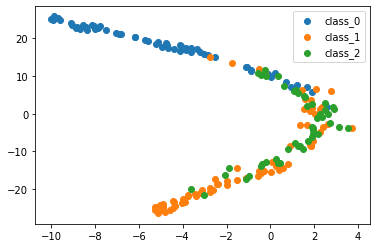

In [57]:
from sklearn import datasets

wine = datasets.load_wine()
plot_tsne(wine.data, wine.target, wine.target_names, perplexity=20)

**Example t-SNE: Digits**

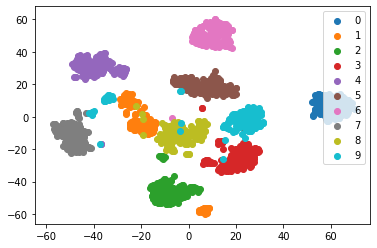

In [59]:
from sklearn import datasets

digits = datasets.load_digits()
plot_tsne(digits.data, digits.target, digits.target_names)

In [60]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### **t-SNE is NOT a magic wand**
- I will NOT go deep for this part